In [155]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import matplotlib.animation as animation
%matplotlib inline

In [156]:
# #    PROPER CONFIGURATION
# L = 50
# N = 20
# delta_theta = np.zeros(N)

# x = np.zeros([N, 2])
# v = np.zeros([N, 2])
# psi = np.random.uniform(-np.pi/4, np.pi/4, N)

# for i in range (int(N/10)):
#     x[10*i:(10*(i+1)), 0] = np.arange(int(L/2 -5), int(L/2 + 5), 1) + np.random.uniform(-0.1, 0.1, 10)
#     x[int(N*i/10): int(N*(i+1)/10), 1] = int(L/2 -i) + np.random.uniform(-0.1, 0.1, int(N/10))

# radii = np.random.normal(1, 0.1, N)

In [157]:
#    TESTING CONFIGURATION
L = 50
N = 20
delta_theta = np.zeros(N)

x = np.zeros([N, 2])
v = np.zeros([N, 2])
psi = np.array([2*np.pi/N * i for i in range(N)])
radii = np.zeros(N)

x[:, 0] = np.array([5*np.cos(2*np.pi/N * i)+25 for i in range(N)]) 
x[:, 1] = np.array([5*np.sin(2*np.pi/N * i)+25 for i in range(N)]) 


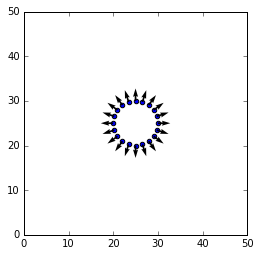

In [158]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim([0, L])
ax.set_ylim([0, L])
ax.set_aspect(1)
plt.scatter(x[:, 0], x[:, 1])
plt.quiver(x[:, 0], x[:, 1], np.cos(psi), np.sin(psi))
plt.show()

In [159]:
def compute_self_propulsion_force(N, psi):
    F_self = np.zeros([N, 2])
    F_self[:, 0] = np.cos(psi)    
    F_self[:, 1] = np.sin(psi)
    
    return F_self

def compute_repulsion_force(N, angles, overlap, k):
    d = np.zeros([N, N, 2])
    d[:, :, 0] = np.cos(angles) * overlap 
    d[:, :, 1] = np.sin(angles) * overlap 
    d = np.sum(d, axis=1)
   
    return k*d

def compute_boundary_force(N, theta_out, psi):
    F_boundary = np.zeros([N, 2])
    F_abs = 0.3 * (theta_out - np.pi) * (theta_out > np.pi)
    F_boundary[:, 0] = F_abs * np.cos(psi)
    F_boundary[:, 1] = F_abs * np.sin(psi)

    return F_boundary
    
#def compute_noise_torque(N):
#    return np.random.uniform(-np.pi/4, np.pi/4, N)
    
def compute_angles(N, neighs, dist_components, psi):
    angles = np.arctan2(dist_components[:, :, 1], dist_components[:, :, 0])
    neigh_angles = neighs*angles
    
    delta_theta = np.zeros(N)
    theta_in = np.zeros(N)
    theta_out = np.zeros(N)
    
    for i in range(N):
        sorted_angles = np.sort(neigh_angles[i, :][np.nonzero(neigh_angles[i, :])])

        if not len(sorted_angles) > 0:
            continue          
            
        angles_difference = sorted_angles - np.roll(sorted_angles, 1) 
        angles_difference[angles_difference<0] += 2*np.pi
        max_index = np.argmax(angles_difference)
        
        if angles_difference[max_index] >= np.pi:
            theta_out[i] = np.abs(angles_difference[max_index])
            theta_in[i] = sorted_angles[max_index-1]  - (2*np.pi - theta_out[i])/2 
            delta_theta[i] = theta_in[i] - psi[i]
      
    return angles, delta_theta, theta_in, theta_out

def update(N, L, x, radii, psi):
    #    Compute distance vector between particles
    dist_components = x[None, :, :] - x[:, None, :]
    dist_components = dist_components - np.rint(dist_components/L)*L
    distances = np.linalg.norm(dist_components, axis = 2)
    
    #    Compute neighbours matrix. Entries are 0 if particles are not neighbours, 1 if they are
    neighs = np.zeros([N, N])
    neighs[(distances < 2.7) & (distances >0)] = 1
    
    #    Compute overlap matrix. Entries are 0 if particles don't overlap, 1 if they are
    overlap = np.zeros([N, N])
    radii_sum = radii[None, :] + radii[:, None]
    
    #    We determine if they overlap by checking if the sum of the radii of the particles
    #    is smaller than their distance
    overlap[distances - radii_sum < 0] = np.abs((distances - radii_sum)[distances - radii_sum < 0])
    np.fill_diagonal(overlap, 0)
    
    #    Compute angles between particles
    angles, delta_theta, theta_in, theta_out = compute_angles(N, neighs, dist_components, psi)
    
   # print(psi)
    print(theta_in[0])
 
    #    Compute all forces
    F_self = compute_self_propulsion_force(N, psi)
    F_repulsion = compute_repulsion_force(N, angles, overlap, 1)
    F_boundary = compute_boundary_force(N, theta_out, psi)   
    F = F_self + F_boundary + F_repulsion
    F = F_boundary
    
    #    Compute all torques
    T_boundary = (theta_in-psi) * (theta_out > np.pi)
    #print(T_boundary)
    #print(T_boundary)
    #T_noise = compute_noise_torque(N, theta_out, psi)

    x += F
    x = np.mod(x, L)
    #psi += T_boundary
    
    return x, psi

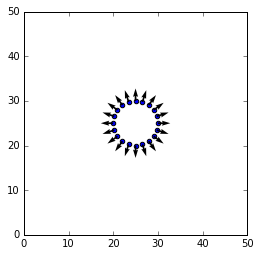

[ 30.  25.]
-3.14159265359


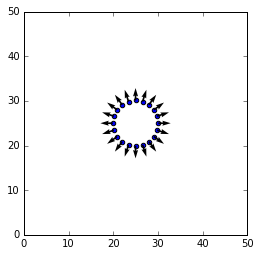

[ 30.09424778  25.        ]
-3.14159265359


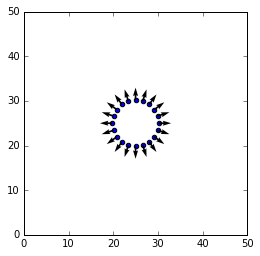

[ 30.18849556  25.        ]
-3.14159265359


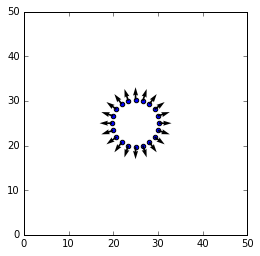

[ 30.28274334  25.        ]
-3.14159265359


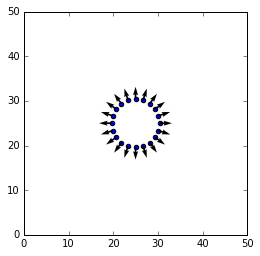

[ 30.37699112  25.        ]
-3.14159265359


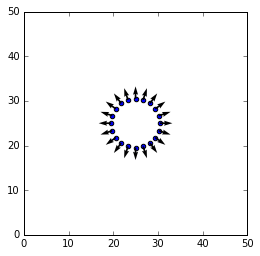

[ 30.4712389  25.       ]
-3.14159265359


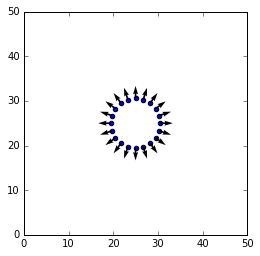

[ 30.56548668  25.        ]
-3.14159265359


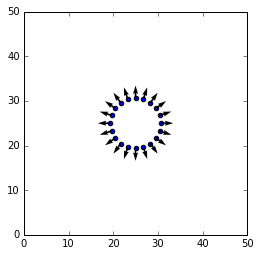

[ 30.65973446  25.        ]
-3.14159265359


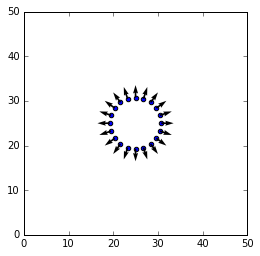

[ 30.75398224  25.        ]
-3.14159265359


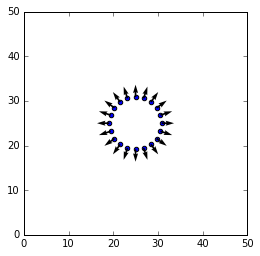

[ 30.84823002  25.        ]
-3.14159265359


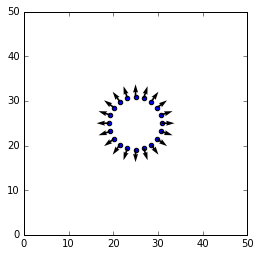

[ 30.9424778  25.       ]
-3.14159265359


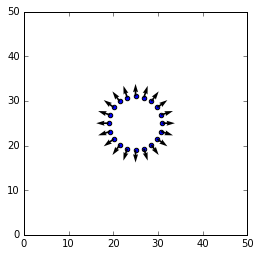

[ 31.03672558  25.        ]
-3.14159265359


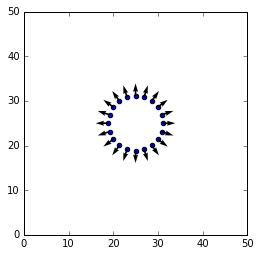

[ 31.13097336  25.        ]
-3.14159265359


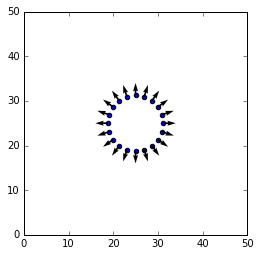

[ 31.22522113  25.        ]
-3.14159265359


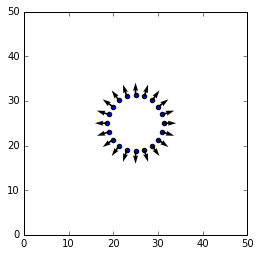

[ 31.31946891  25.        ]
-3.14159265359


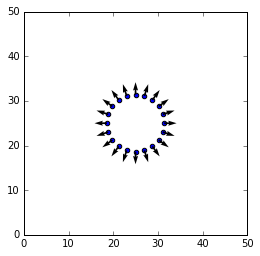

[ 31.41371669  25.        ]
-3.14159265359


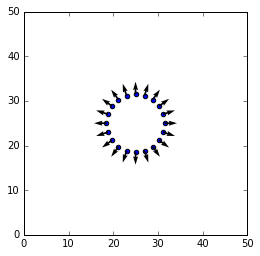

[ 31.50796447  25.        ]
-3.14159265359


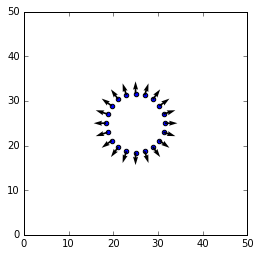

[ 31.60221225  25.        ]
-3.14159265359


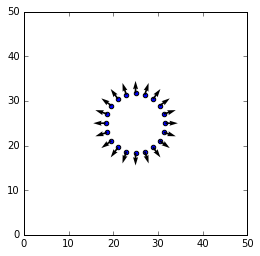

[ 31.69646003  25.        ]
-3.14159265359


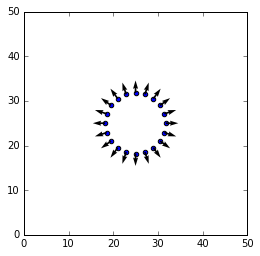

[ 31.79070781  25.        ]
-3.14159265359


In [160]:
for i in range(20):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim([0, L])
    ax.set_ylim([0, L])
    ax.set_aspect(1)
    plt.scatter(x[:, 0], x[:, 1])
    plt.quiver(x[:, 0], x[:, 1], np.cos(psi), np.sin(psi))
    plt.show()
    x, psi = update(N, L, x, radii, psi)
